# Univariate Modelling

In [1]:
import os
import joblib

stored_models = [file for file in os.listdir() if file.endswith('.model.pkl')]
stored_models

['XGBRegressor.model.pkl',
 'HistGradientBoostingRegressor.model.pkl',
 'LassoLarsIC.model.pkl']

In [2]:
from sklearn.ensemble import VotingRegressor

estimators = []
for model_file in stored_models:
    print(f'Loading {model_file}')
    model = joblib.load(model_file)
    estimators.append((
        model_file.replace('.model.pkl', ''),
        model
    ))

estimators

Loading XGBRegressor.model.pkl
Loading HistGradientBoostingRegressor.model.pkl
Loading LassoLarsIC.model.pkl


[('XGBRegressor',
  XGBRegressor(alpha=3.236541693930851e-08, base_score=None, booster=None,
               callbacks=None, colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.4143670393240836, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
               importance_type=None, interaction_constraints=None, lambda=10.0,
               learning_rate=0.3, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
               max_leaves=None, min_child_weight=8, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=464,
               n_jobs=None, ...)),
 ('HistGradientBoostingRegressor',
  HistGradientBoostingRegressor(early_stopping=False, l2_regularization=1.0,
                                learning_rate=0.2, max_depth=11, max_iter=500,
                 

In [3]:
import os
import pandas as pd

train_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(train_data_file, index_col=0, low_memory=False)

validation_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_4_55h.csv')
validation_data = pd.read_csv(validation_data_file, index_col=0, low_memory=False)

additional_train_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_3h.csv')
additional_train_data = pd.read_csv(additional_train_data_file, index_col=0, low_memory=False)
# remove from additional data patients that are not in validation data ids
additional_train_data = additional_train_data[~additional_train_data.index.isin(validation_data.index.unique())]

# merge train and additional data
train_data = pd.concat([train_data, additional_train_data], axis=0)

# do not train with patients that are not have to be predicted
test_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'test.csv')
test_data = pd.read_csv(test_data_file, index_col=0, low_memory=False)

unique_patients = test_data['p_num'].unique()
train_data = train_data[train_data['p_num'].isin(unique_patients)]
validation_data = validation_data[validation_data['p_num'].isin(unique_patients)]
test_data = test_data[test_data['p_num'].isin(unique_patients)]

train_data.head()

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


## Predict for validation data and check results

[Voting] ............. (1 of 3) Processing XGBRegressor, total= 1.0min
[Voting]  (2 of 3) Processing HistGradientBoostingRegressor, total= 1.1min
[Voting] .............. (3 of 3) Processing LassoLarsIC, total=   1.6s
RMSE: 1.8862087442064055
R2: 0.6763452392873898


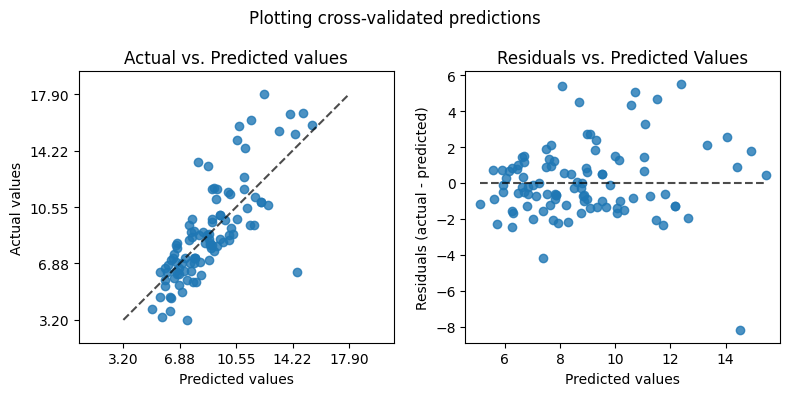

In [4]:
# Load, preprocess and standardize the train and validation data for prediction for validation data
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(train_data)
validation_data_transformed = pipeline.transform(validation_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_validation = validation_data_transformed.drop(columns=['bg+1:00'])
y_validation = validation_data_transformed['bg+1:00']

ensemble = VotingRegressor(estimators=estimators, verbose=True)
ensemble.fit(X=X_train, y=y_train)
ensemble.score(X=X_train, y=y_train)

# show the results
from sklearn.metrics import root_mean_squared_error, r2_score, PredictionErrorDisplay
import matplotlib.pyplot as plt

y_validation_pred = ensemble.predict(X=X_validation)

print(f'RMSE: {root_mean_squared_error(y_true=y_validation, y_pred=y_validation_pred)}')
print(f'R2: {r2_score(y_true=y_validation, y_pred=y_validation_pred)}')

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_true=y_validation,
    y_pred=y_validation_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_true=y_validation,
    y_pred=y_validation_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show();

In [5]:
diffs = y_validation - y_validation_pred
diffs.sort_values()
diffs

id
p01_test_59      -1.273733
p01_test_403     -1.691728
p01_test_731      1.124176
p01_test_1184     1.251767
p01_test_1758     0.376430
                    ...   
p24_test_93252   -0.525434
p24_test_93610    3.557988
p24_test_94081   -0.909869
p24_test_94398    1.898784
p24_test_94938   -1.777421
Name: bg+1:00, Length: 5053, dtype: float64

## Predict for test data and prepare submission file

In [6]:
# Load, preprocess and standardize the train and validation data for prediction for test data 
from pipelines import pipeline

train_and_validation_data = pipeline.fit_transform(pd.concat([train_data, validation_data]))

X = train_and_validation_data.drop(columns=['bg+1:00'])
y = train_and_validation_data['bg+1:00']

ensemble = VotingRegressor(estimators=estimators, verbose=True)
ensemble.fit(X=X, y=y)
ensemble.score(X=X, y=y)

# evaluate the model


[Voting] ............. (1 of 3) Processing XGBRegressor, total= 1.0min
[Voting]  (2 of 3) Processing HistGradientBoostingRegressor, total=  44.7s
[Voting] .............. (3 of 3) Processing LassoLarsIC, total=   1.1s


0.8549361589726117

# Prepare test results

In [7]:
from pipelines import pipeline

test_data = pipeline.transform(test_data)
test_data.head()

,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,1.064975,1.012231,0.958403,1.012055,1.066904,1.120679,1.227764,1.336441,1.443771,1.539672,...,0,0,0,0,0,0,0,0,0,0
p01_8460,-0.496393,-0.313560,-0.130231,0.053090,0.171845,0.290494,0.408872,0.344504,0.279748,0.214974,...,0,0,0,0,0,0,0,0,0,0
p01_8461,-0.690218,-0.809385,-0.927843,-1.045949,-1.100648,-1.154242,-1.207365,-1.164966,-1.121392,-1.077415,...,1,0,0,0,0,0,0,0,0,0
p01_8462,-1.368606,-1.369882,-1.369764,-1.379970,-1.391812,-1.402220,-1.390538,-1.380605,-1.369286,-1.400512,...,0,0,0,0,0,0,0,0,0,0
p01_8463,0.149690,0.096034,0.042226,-0.011559,-0.130102,-0.248587,-0.366922,-0.528832,-0.690272,-0.851247,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Predict the bg+1:00 values
test_data['bg+1:00'] = ensemble.predict(test_data)
test_data.head()

/var/folders/g7/z7m625rj50d5ptztzplh4wgc0000gn/T/ipykernel_48898/2106341811.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['bg+1:00'] = ensemble.predict(test_data)


,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,1.064975,1.012231,0.958403,1.012055,1.066904,1.120679,1.227764,1.336441,1.443771,1.539672,...,0,0,0,0,0,0,0,0,0,8.649014
p01_8460,-0.496393,-0.313560,-0.130231,0.053090,0.171845,0.290494,0.408872,0.344504,0.279748,0.214974,...,0,0,0,0,0,0,0,0,0,6.071259
p01_8461,-0.690218,-0.809385,-0.927843,-1.045949,-1.100648,-1.154242,-1.207365,-1.164966,-1.121392,-1.077415,...,0,0,0,0,0,0,0,0,0,8.168799
p01_8462,-1.368606,-1.369882,-1.369764,-1.379970,-1.391812,-1.402220,-1.390538,-1.380605,-1.369286,-1.400512,...,0,0,0,0,0,0,0,0,0,10.068185
p01_8463,0.149690,0.096034,0.042226,-0.011559,-0.130102,-0.248587,-0.366922,-0.528832,-0.690272,-0.851247,...,0,0,0,0,0,0,0,0,0,6.752988


## Prepare the submission file

In [9]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.649014
p01_8460,6.071259
p01_8461,8.168799
p01_8462,10.068185
p01_8463,6.752988
...,...
p24_256,6.226071
p24_257,10.160485
p24_258,6.973906


### Save the submission file

In [10]:
submission.to_csv(f'submission-{os.path.basename(os.getcwd())}.csv')